In [1]:
!pip install tokenization

In [2]:
# imports
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)  

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd 'drive/My Drive/Workspaces/machinelearning/Projects/Udacity MLND/Capstone Project'

/content/drive/My Drive/Workspaces/machinelearning/Projects/Udacity MLND/Capstone Project


In [6]:
# %cd 'drive/My Drive/Workspaces/machinelearning/Projects/Udacity MLND/Capstone Project'


#gather data
train_df = pd.read_csv('data/train.csv') #trainig data
test_df = pd.read_csv('data/test.csv') #test data

print('Training Set Shape = {}'.format(train_df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_df.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_df.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


Handle missing data

          Total   Percent
location   2533  0.332720
keyword      61  0.008013
target        0  0.000000
text          0  0.000000
id            0  0.000000
          Total   Percent
location   1105  0.338645
keyword      26  0.007968
text          0  0.000000
id            0  0.000000


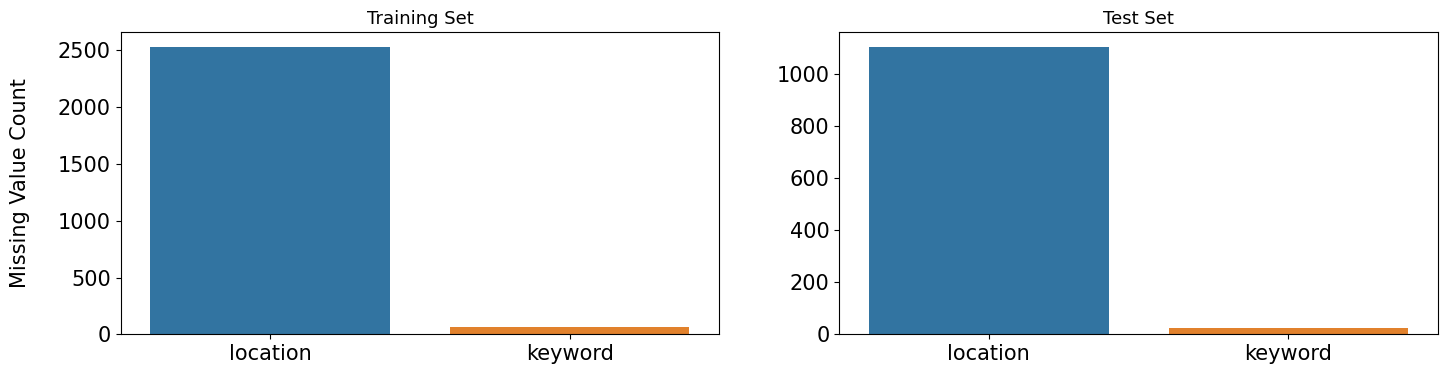

In [7]:
total_train = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total_train, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data_train.head())

total_test = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data_test.head())

missingDataColList_train = missing_data_train[missing_data_train.Total > 0].index.tolist()
missingDataColList_test = missing_data_test[missing_data_test.Total > 0].index.tolist()

#Plot the missing values

fig, axes = plt.subplots(ncols=len(missingDataColList_train), figsize=(17, 4), dpi=100)

sns.barplot(x=train_df[missingDataColList_train].isnull().sum().index, y=train_df[missingDataColList_train].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_df[missingDataColList_test].isnull().sum().index, y=test_df[missingDataColList_test].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train_df, test_df]:
    for col in missingDataColList_train:
        df[col] = df[col].fillna(f'no_{col}')


In [8]:
missingDataColList_train = missing_data_train[missing_data_train.Total > 0].index.tolist()
missingDataColList_test = missing_data_test[missing_data_test.Total > 0].index.tolist()

In [9]:
print('Number of unqiue keywords:' , train_df.keyword.nunique(), ' in training set, and ',test_df.keyword.nunique(), ' in test set.')
print('Number of unqiue locations:' , train_df.location.nunique(), ' in training set, and ',test_df.location.nunique(), ' in test set.')

Number of unqiue keywords: 222  in training set, and  222  in test set.
Number of unqiue locations: 3342  in training set, and  1603  in test set.


In [10]:
train_df.groupby(['keyword','target']).head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7547,10788,wrecked,United States,I wonder how times someone has wrecked trying ...,0
7548,10789,wrecked,Pennsylvania,Four hundred wrecked cars (costing $100 apiece...,0
7552,10795,wrecked,"Santa Cruz, CA",Israel wrecked my home. Now it wants my land. ...,1
7559,10808,wrecked,no_location,300K exotic car wrecked in train accident \nht...,1


keyword     target
ablaze      0         23
            1         13
accident    0         11
            1         24
aftershock  0         34
                      ..
wreck       0         30
            1          7
wreckage    1         39
wrecked     0         36
            1          3
Name: target, Length: 440, dtype: int64


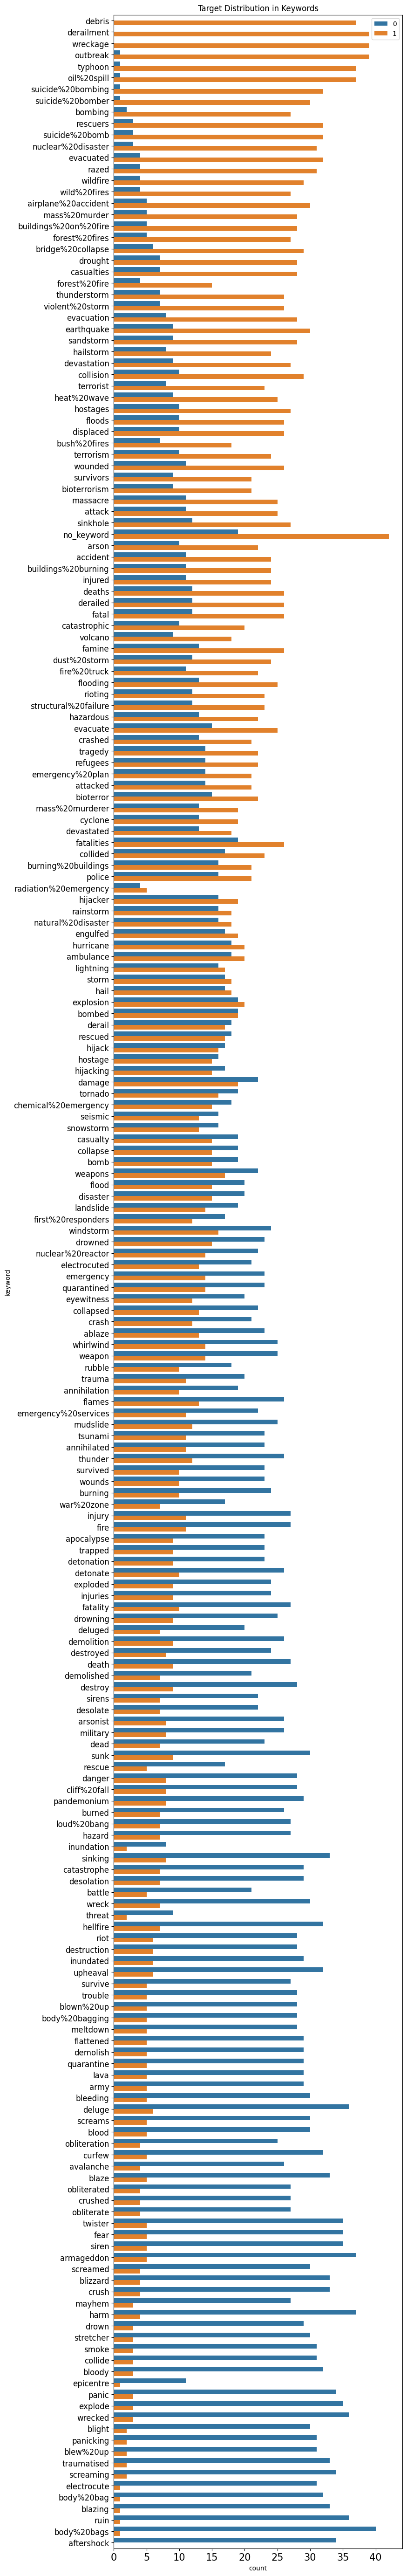

In [11]:
print(train_df.groupby(['keyword','target']).target.count())

train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

**Meta features**

Tweets are not simple string of texts, but from which different types of inferences could be drawn.
Also, tweets have features like mentions, hashtags (for trends), urls, etc.
Taking those data along with text stats, into consideration would be really useful to judge the data.



1. Getting the meta features

In [16]:
METAFEATURES = []

# word count
train_df['word_count'] = train_df['text'].apply(lambda tweet: len(str(tweet).split()))
test_df['word_count'] = test_df['text'].apply(lambda tweet: len(str(tweet).split()))
METAFEATURES.append('word_count')

# unique_word_count
train_df['unique_word_count'] = train_df.text.apply(lambda tweet: len(set(str(tweet).split())))
test_df['unique_word_count'] = test_df.text.apply(lambda tweet: len(set(str(tweet).split())))
METAFEATURES.append('unique_word_count')

# stop_word_count
train_df['stopword_count'] = train_df.text.apply(lambda tweet: len([word for word in str(tweet).split() if word in STOPWORDS]))
test_df['stopword_count'] = test_df.text.apply(lambda tweet: len([word for word in str(tweet).split() if word in STOPWORDS]))
METAFEATURES.append('stopword_count')

# url_count
train_df['url_count'] = train_df.text.apply(lambda tweet: len([word for word in tweet.split() if ('https' in word or 'http' in word)]))
test_df['url_count'] = test_df.text.apply(lambda tweet: len([word for word in tweet.split() if ('https' in word or 'http' in word)]))
METAFEATURES.append('url_count')

#mean_word_length
train_df['mean_word_length'] = train_df.text.apply(lambda tweet: np.mean([len(word) for word in tweet.split()]))
test_df['mean_word_length'] = test_df.text.apply(lambda tweet: np.mean([len(word) for word in tweet.split()]))
METAFEATURES.append('mean_word_length')

# char count
train_df['char_count'] = train_df.text.apply(lambda tweet: len(str(tweet)))
test_df['char_count'] = test_df.text.apply(lambda tweet: len(str(tweet)))
METAFEATURES.append('char_count')

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda tweet: len([word for word in str(tweet) if word in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda tweet: len([word for word in str(tweet) if word in string.punctuation]))
METAFEATURES.append('punctuation_count')

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda tweet: len([word for word in str(tweet) if word == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda tweet: len([word for word in str(tweet) if word == '#']))
METAFEATURES.append('hashtag_count')

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda tweet: len([word for word in str(tweet) if word == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda tweet: len([word for word in str(tweet) if word == '@']))
METAFEATURES.append('mention_count')


2. Visualizing the Meta features and drawing inferences from it

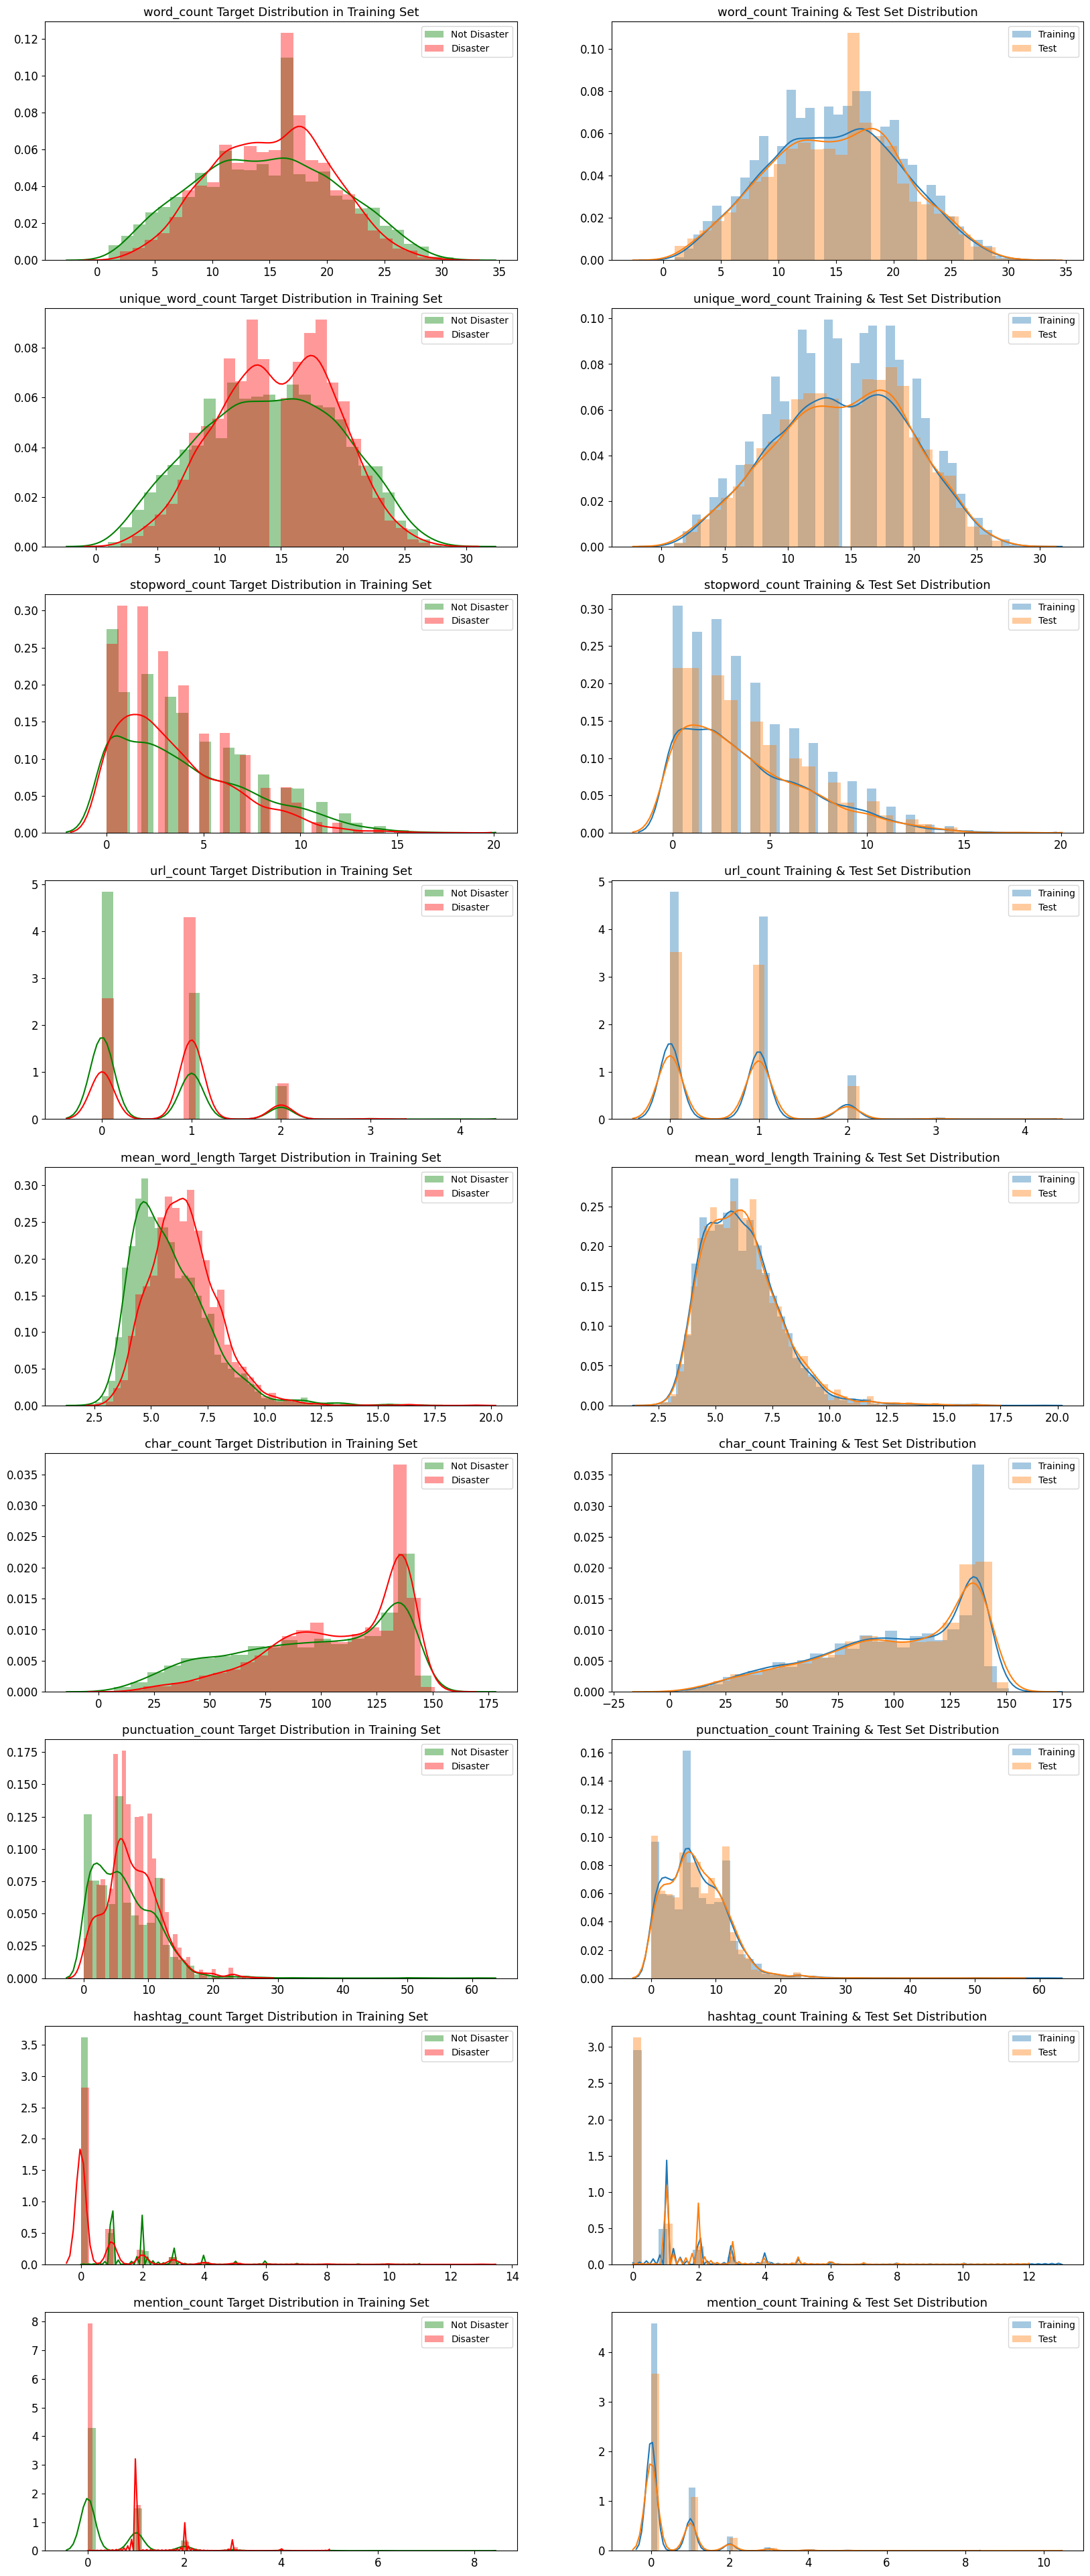

In [18]:
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()



> **INFERENCES on investigating the meta features**

> All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

> All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

> On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.




In [14]:
train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stopword_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,5,0,4.384615,69,1,1,0
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,9,0,5.090909,133,3,0,0
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,6,0,4.500000,88,2,2,0
